In [1]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [2]:
#adapted from
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [3]:
# Step 1. Load Dataset
import pandas as pd
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full

,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,2004,40,0.982275,0.897159,877,1256,185,3171,1176,353449
1,2004,41,1.018210,1.022480,1071,1373,216,3631,1187,355116
2,2004,42,1.176800,1.062960,1240,1534,226,4019,1267,378094
3,2004,43,1.301210,1.146960,1190,1671,285,4369,1293,380921
4,2004,44,1.277460,1.204950,1327,1718,291,4551,1302,377692
...,...,...,...,...,...,...,...,...,...,...
804,2020,10,5.130780,5.290100,13581,25957,5586,77452,2853,1464094
805,2020,11,5.631160,6.345940,13834,27321,6603,88341,2769,1392087
806,2020,12,6.357030,7.450870,10612,17276,6925,77817,2697,1044402
807,2020,13,5.178310,6.391350,5064,8245,6393,52802,2561,826148


In [4]:
import matplotlib.pyplot as plt
plt.plot(ilinet_full['ILITOTAL'])

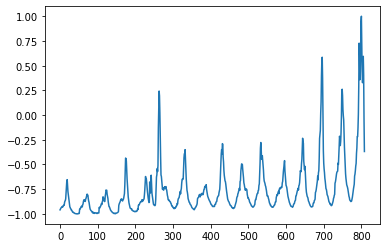

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
ilinet_full['ILITOTAL']=scaler.fit_transform(ilinet_full['ILITOTAL'].values.reshape(-1, 1))
plt.plot(ilinet_full['ILITOTAL'])

In [6]:
end_weeks=ilinet_full.index[ilinet_full['WEEK'] == 39].tolist()
start_weeks=ilinet_full.index[ilinet_full['WEEK'] == 40].tolist()

In [7]:
print(end_weeks)
train_data_size = 729

# divide data into training and testing,
train_data =ilinet_full['ILITOTAL'].values[0:train_data_size]
test_data =ilinet_full['ILITOTAL'].values[train_data_size:]
print(len(train_data))
print(len(test_data))

[51, 103, 155, 207, 260, 312, 364, 416, 468, 520, 573, 625, 677, 729, 781]
729
80


In [8]:
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data, train_window)

In [9]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [12]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01850742
epoch:  26 loss: 0.00065180
epoch:  51 loss: 0.00001893
epoch:  76 loss: 0.00050087
epoch: 101 loss: 0.00031161
epoch: 126 loss: 0.00017127
epoch: 149 loss: 0.0001179104


In [16]:
fut_pred = 52

test_inputs = train_data[-train_window:].tolist()
print(test_inputs)

[-0.8511930704116821, -0.7825999855995178, -0.7747920155525208, -0.7556005716323853, -0.7279991507530212, -0.7054327130317688, -0.6691659092903137, -0.6174474358558655, -0.6553196310997009, -0.5835157632827759, -0.5615696310997009, -0.44213369488716125, -0.23635435104370117, -0.19123978912830353, -0.15449868142604828, 0.018662434071302414, 0.1331363171339035, 0.3938266336917877, 0.5517914295196533, 0.5853582620620728, 0.3734675943851471, -0.04949284717440605, -0.35890981554985046, -0.48535099625587463, -0.5436369180679321, -0.5825489163398743, -0.6393206119537354, -0.6688557863235474, -0.7128210663795471, -0.7455669641494751, -0.7513499855995178, -0.7743542194366455, -0.8048562407493591, -0.8149445652961731, -0.8226065635681152, -0.8415426015853882, -0.8582348227500916, -0.8786668181419373, -0.8823153972625732, -0.890086829662323, -0.9026561379432678, -0.8982231616973877, -0.9112668037414551, -0.9165389537811279, -0.9144410490989685, -0.909898579120636, -0.8975663781166077, -0.88322752

In [17]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [19]:
import numpy as np
actual_predictions = np.array(test_inputs[train_window:])
print(actual_predictions)

[-0.779612   -0.74931288 -0.71462142 -0.67837191 -0.63914889 -0.59655929
 -0.54993582 -0.49871498 -0.44251308 -0.38089985 -0.31460103 -0.24515797
 -0.16751969 -0.06213091  0.07820395  0.20663098  0.29048121  0.26639646
  0.09577113 -0.13718608 -0.31477717 -0.42196843 -0.49392995 -0.55314952
 -0.6011579  -0.63867605 -0.66735673 -0.68895698 -0.70517862 -0.71755821
 -0.72737503 -0.73565245 -0.74320579 -0.75062871 -0.75829768 -0.76642054
 -0.77505213 -0.78409702 -0.79333919 -0.8024528  -0.81106269 -0.81878752
 -0.82529694 -0.83034277 -0.8337791  -0.83555245 -0.83567715 -0.83420855
 -0.83121264 -0.82674539 -0.82085067 -0.81352907]


[729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746
 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764
 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780]


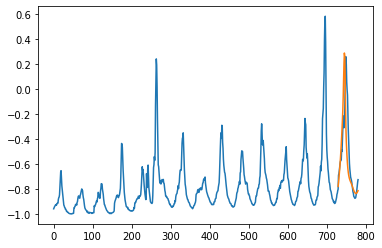

In [20]:
x = np.arange(len(train_data), len(train_data)+52, 1)
print(x)
plt.plot(ilinet_full['ILITOTAL'].values[0:len(train_data)+52])
plt.plot(x,actual_predictions)
plt.show()

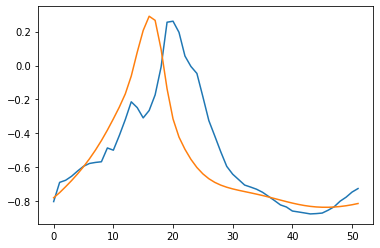

In [21]:
plt.plot(ilinet_full['ILITOTAL'].values[len(train_data):len(train_data)+52])
plt.plot(actual_predictions)
plt.show()

Next steps:

- use less training data to predict

- smaller training window (try 10 instead of 52)

- use hopitalization data instread of total case counts (easy change)

- try a more sophisticated model
